In [1]:
import sys
import pandas as pd
import os
from intervaltree import IntervalTree

In [19]:
def asari_to_trees(ft, mz_err=5, rtime=5):
    mz_tree, rt_tree = IntervalTree(), IntervalTree()
    for id, mz, rtime in zip(ft['id_number'], ft['mz'], ft['rtime']):
        mz_tree.addi(mz - (mz/1e6 * mz_err), mz + (mz/1e6 * mz_err), id)
        rt_tree.addi(rtime-10, rtime+10, id)
    return mz_tree, rt_tree

def metaboanalyst_to_trees(r_ft, mz_err=5, rtime=5):
    mz_tree, rt_tree = IntervalTree(), IntervalTree()
    for feature in r_ft['Sample'][1:]:
        mz, rtime = [float(x) for x in feature.split('__')]
        mz_tree.addi(mz - (mz/1e6 * mz_err), mz + (mz/1e6 * mz_err), feature)
        rt_tree.addi(rtime-10, rtime+10, feature)
    return mz_tree, rt_tree

def compare_R_to_asari(r_ft, asari_mz_tree, asari_rt_tree):
    total, matched = 0, 0
    for feature in r_ft['Sample'][1:]:
        mz, rtime = [float(x) for x in feature.split('__')]
        rt_matches = [x.data for x in asari_rt_tree.at(rtime)]
        mz_matches = [x.data for x in asari_mz_tree.at(mz)]
        feature_matched = False
        total += 1
        for match in rt_matches:
            if match in mz_matches:
                feature_matched = True
        if feature_matched:
            matched += 1
    return total, matched

def compare_asari_to_R(a_ft, r_mz_tree, r_rt_tree):
    total, matched = 0, 0
    for _, mz, rtime in zip(a_ft['id_number'], a_ft['mz'], a_ft['rtime']):
        rt_matches = [x.data for x in r_rt_tree.at(rtime)]
        mz_matches = [x.data for x in r_mz_tree.at(mz)]
        feature_matched = False
        total += 1
        for match in rt_matches:
            if match in mz_matches:
                feature_matched = True
        if feature_matched:
            matched += 1
    return total, matched

In [29]:

def search_trees(reference_db, mz_tree, rt_tree):
    matches = {}
    for name, mz, rtime in zip(reference_db["Metabolite"], reference_db["m/z"], reference_db["Retention time (min)"]):
        matches[name] = set()
        rtime = rtime * 60
        mz_matches = [x.data for x in mz_tree.at(mz)]
        rt_matches = [x.data for x in rt_tree.at(rtime)]
        for mz_match in mz_matches:
            if mz_match in rt_matches:
                matches[name].add(mz_match)
    matched = 0
    for name, features in matches.items():
        if features:
            matched += 1
    return len(matches), matched, set([x for x, v in matches.items() if v])




In [30]:
checkmate_annots = pd.read_excel("/Users/mitchjo/Projects/PythonCentricPipelineForMetabolomics/examples/manuscript_notebooks/pcpfm_vs_metaboanalystR/CheckMate_annots.xlsx")
checkmate_orbi_asari = pd.read_csv("/Users/mitchjo/Projects/PythonCentricPipelineForMetabolomics/examples/Analyses/checkmate_orbi_subset/asari_asari_project_12394755/preferred_Feature_table.tsv", sep="\t")
checkmate_orbi_metaboanalyst = pd.read_csv("/Users/mitchjo/Downloads/MetaboAnalystr_results/Checkmate_Orbi_results.csv")
asari_mz_tree, asari_rt_tree = asari_to_trees(checkmate_orbi_asari)
r_mz_tree, r_rt_tree = metaboanalyst_to_trees(checkmate_orbi_metaboanalyst)
total, matched = compare_R_to_asari(checkmate_orbi_metaboanalyst, asari_mz_tree, asari_rt_tree)
print("Total Metaboanalyst: ", total, " Matched to Asari: ", matched)
total, matched = compare_asari_to_R(checkmate_orbi_asari, asari_mz_tree, asari_rt_tree)
print("Total Asari: ", total, " Matched to Metaboanalyst: ", matched)
a_total, asari_found, asari_found_set = search_trees(checkmate_annots, asari_mz_tree, asari_rt_tree)
r_total, r_found, r_found_set = search_trees(checkmate_annots, r_mz_tree, r_rt_tree)
all_standards = checkmate_annots["Metabolite"]

print(print("Total Standards: ", a_total, " Asari Found: ", asari_found))
print(print("Total Standards: ", r_total, " Metaboanalyst Found: ", r_found))


Total Metaboanalyst:  3902  Matched to Asari:  2567
Total Asari:  16593  Matched to Metaboanalyst:  16593
Total Standards:  201  Asari Found:  156
None
Total Standards:  201  Metaboanalyst Found:  149
None


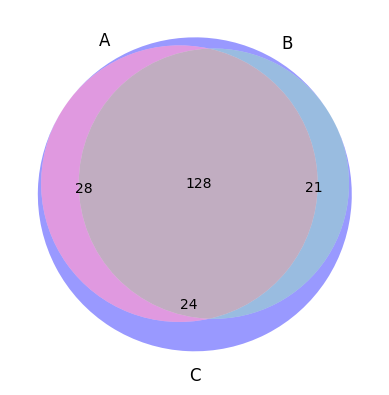

In [36]:
import matplotlib.pyplot as plt



A = asari_found_set
B = r_found_set
C = set([x for x in all_standards])

from matplotlib_venn import venn3
venn3([len(A.difference(B.union(C))),
      len(B.difference(A.union(C))),
      len(A.intersection(B).difference(C)),
      len(C.difference(A.union(B))),
      len(A.intersection(C).difference(B)),
      len(B.intersection(C).difference(A)),
      len(A.intersection(B).intersection(C))])
plt.show()

In [37]:
checkmate_annots = pd.read_excel("/Users/mitchjo/Projects/PythonCentricPipelineForMetabolomics/examples/manuscript_notebooks/pcpfm_vs_metaboanalystR/CheckMate_annots.xlsx")
checkmate_orbi_asari = pd.read_csv("/Users/mitchjo/Projects/PythonCentricPipelineForMetabolomics/examples/Analyses/checkmate_orbi_subset/asari_asari_project_12394755/export/full_Feature_table.tsv", sep="\t")
checkmate_orbi_metaboanalyst = pd.read_csv("/Users/mitchjo/Downloads/MetaboAnalystr_results/Checkmate_Orbi_results.csv")
asari_mz_tree, asari_rt_tree = asari_to_trees(checkmate_orbi_asari)
r_mz_tree, r_rt_tree = metaboanalyst_to_trees(checkmate_orbi_metaboanalyst)
total, matched = compare_R_to_asari(checkmate_orbi_metaboanalyst, asari_mz_tree, asari_rt_tree)
print("Total Metaboanalyst: ", total, " Matched to Asari: ", matched)
total, matched = compare_asari_to_R(checkmate_orbi_asari, asari_mz_tree, asari_rt_tree)
print("Total Asari: ", total, " Matched to Metaboanalyst: ", matched)
a_total, asari_found, asari_found_set = search_trees(checkmate_annots, asari_mz_tree, asari_rt_tree)
r_total, r_found, r_found_set = search_trees(checkmate_annots, r_mz_tree, r_rt_tree)
all_standards = checkmate_annots["Metabolite"]

print(print("Total Standards: ", a_total, " Asari Found: ", asari_found))
print(print("Total Standards: ", r_total, " Metaboanalyst Found: ", r_found))

Total Metaboanalyst:  3902  Matched to Asari:  3396
Total Asari:  32515  Matched to Metaboanalyst:  32515
Total Standards:  201  Asari Found:  189
None
Total Standards:  201  Metaboanalyst Found:  149
None


/Users/mitchjo/Library/Python/3.9/lib/python/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


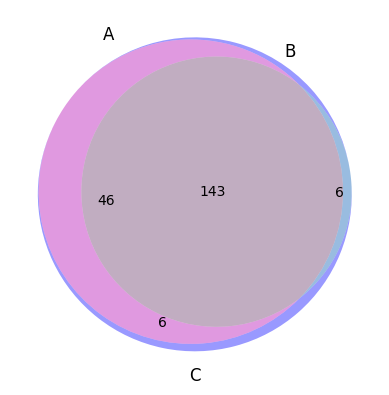

In [38]:
import matplotlib.pyplot as plt



A = asari_found_set
B = r_found_set
C = set([x for x in all_standards])

from matplotlib_venn import venn3
venn3([len(A.difference(B.union(C))),
      len(B.difference(A.union(C))),
      len(A.intersection(B).difference(C)),
      len(C.difference(A.union(B))),
      len(A.intersection(C).difference(B)),
      len(B.intersection(C).difference(A)),
      len(A.intersection(B).intersection(C))])
plt.show()